In [1]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
#plt.style.use('fivethirtyeight')

In [2]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data # Create a copy for us to work with 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, 
          inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
    king_data = salmon_copy.filter(["date","king"], axis=1)
    print(king_data)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [3]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
    king_all_copy, king_data= load_data(chris_path)
    print(king_all_copy)

            date  king
0     1938-05-01   201
1     1938-05-02   227
2     1938-05-03    78
3     1938-05-04    37
4     1938-05-05    29
...          ...   ...
24729 2021-04-28  2433
24730 2021-04-29  4782
24731 2021-04-30  4641
24732 2021-05-01  2087
24733 2021-05-02  2517

[24734 rows x 2 columns]
            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [4]:
data_copy = king_all_copy
data_copy['date']
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [5]:
print(data_copy)
data_copy.shape
forecast_set = data_copy

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


In [6]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [7]:
print(data_copy)

          date    king
0   1939-01-31       6
1   1939-02-28      12
2   1939-03-31     121
3   1939-04-30   51410
4   1939-05-31   25159
..         ...     ...
979 2020-08-31  105269
980 2020-09-30  254930
981 2020-10-31   30917
982 2020-11-30     843
983 2020-12-31       9

[984 rows x 2 columns]


In [77]:
def create_train_test(king_all):
    king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
    king_training = king_all[king_training_parse]
    king_training = king_training.reset_index()
    king_training = king_training.drop('index', axis=1)
    
    king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
    king_test = king_all[king_test_parse]
    king_test = king_test.reset_index()
    king_test = king_test.drop('index', axis=1)

    
    # Normalizing Data
    king_training[king_training["king"] < 0] = 0 
    king_test[king_test["king"] < 0] = 0
    king_train_pre = king_training["king"].to_frame()
    king_test_pre = king_test["king"].to_frame()
    scaler = MinMaxScaler(feature_range=(0, 1))
    king_train_norm = scaler.fit_transform(king_train_pre)
    king_test_norm = scaler.fit_transform(king_test_pre)
    
    # create lists to be filled 
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    y_test_not_norm = []
    y_train_not_norm = []
    
    # Todo: Experiment with input size of input (ex. 30 days)
    
    for i in range(6,924): # 30
        x_train.append(king_train_norm[i-6:i])
        y_train.append(king_train_norm[i])
    for i in range(6, 60):
        x_test.append(king_test_norm[i-6:i])
        y_test.append(king_test_norm[i])
    
    # make y_test_not_norm
    for i in range(6, 60):
        y_test_not_norm.append(king_test['king'][i])
    for i in range(6,924): # 30
        y_train_not_norm.append(king_training['king'][i])
        
    return x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm

In [78]:
x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm = create_train_test(data_copy)

# Make arrays for train and test 
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1])).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1]))
y_train = np.array(y_train)
y_test = np.array(y_test)

# Make arrays for y train and test for testing of normalization 
y_test_not_norm = np.array(y_test_not_norm)
y_test_not_norm = y_test_not_norm.reshape((y_test_not_norm.shape[0], 1))
y_train_not_norm = np.array(y_train_not_norm)
y_train_not_norm = y_train_not_norm.reshape((y_train_not_norm.shape[0], 1))



In [79]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    
def day_to_year(day_preds):
    day_preds = day_preds[183:]
    year_preds = []
    for i in range(365, len(day_preds), 365):   
        salmon_count = np.sum(day_preds[i - 365:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

In [75]:
def create_nn_model(x_train, y_train, x_test, y_test, scaler):
    '''
    create nn model trained on x_train and y_train
    and make predictions on the x_test data
    '''
    # create a model
    model = Sequential()
    model.add(Dense(32, input_dim = (x_train.shape[1]), activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(8, activation = 'relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer = 'adam')
    
    history = model.fit(x_train, y_train, epochs = 3000, batch_size = 100)
    
    # Predictions
    nn_train_predict = model.predict(x_train)
    nn_test_predict = model.predict(x_test)
    
    # Descale 
    nn_train_predict = scaler.inverse_transform(nn_train_predict)
    y_train = scaler.inverse_transform(y_train)
    nn_test_predict = scaler.inverse_transform(nn_test_predict)
    nn_test_predict = nn_test_predict.astype(np.int64)
    y_test = scaler.inverse_transform(y_test)
    
    return model, nn_train_predict, nn_test_predict, history, y_train, y_test

In [76]:
# train nn model 
print(x_train.shape)
model, nn_train_preds, nn_test_preds, history_nn, y_train, y_test = create_nn_model(x_train, y_train, x_test, y_test, scaler)

(918, 6)
Epoch 1/3000
10/10 [==============================] - 0s 980us/step - loss: 991432680.7273
Epoch 2/3000
10/10 [==============================] - 0s 2ms/step - loss: 1120946321.4545
Epoch 3/3000
10/10 [==============================] - 0s 2ms/step - loss: 956586932.3636
Epoch 4/3000
10/10 [==============================] - 0s 2ms/step - loss: 980322176.0000
Epoch 5/3000
10/10 [==============================] - 0s 3ms/step - loss: 734022644.3636
Epoch 6/3000
10/10 [==============================] - 0s 2ms/step - loss: 870754330.1818
Epoch 7/3000
10/10 [==============================] - 0s 1ms/step - loss: 1026949143.2727
Epoch 8/3000
10/10 [==============================] - 0s 2ms/step - loss: 964317201.4545
Epoch 9/3000
10/10 [==============================] - 0s 2ms/step - loss: 1026203031.2727
Epoch 10/3000
10/10 [==============================] - 0s 2ms/step - loss: 831096314.1818
Epoch 11/3000
10/10 [==============================] - 0s 2ms/step - loss: 905880186.1818
Epoch

10/10 [==============================] - 0s 2ms/step - loss: 889256814.5455
Epoch 182/3000
10/10 [==============================] - 0s 1ms/step - loss: 970593384.7273
Epoch 183/3000
10/10 [==============================] - 0s 1ms/step - loss: 898006196.3636
Epoch 184/3000
10/10 [==============================] - 0s 1ms/step - loss: 659172029.0909
Epoch 185/3000
10/10 [==============================] - 0s 1ms/step - loss: 809535092.3636
Epoch 186/3000
10/10 [==============================] - 0s 1ms/step - loss: 926902597.8182
Epoch 187/3000
10/10 [==============================] - 0s 1ms/step - loss: 781097629.0909
Epoch 188/3000
10/10 [==============================] - 0s 1ms/step - loss: 685241175.2727
Epoch 189/3000
10/10 [==============================] - 0s 1ms/step - loss: 651542868.3636
Epoch 190/3000
10/10 [==============================] - 0s 1ms/step - loss: 800121966.5455
Epoch 191/3000
10/10 [==============================] - 0s 1ms/step - loss: 701725044.3636
Epoch 192/3000

10/10 [==============================] - 0s 1ms/step - loss: 768507746.9091
Epoch 360/3000
10/10 [==============================] - 0s 2ms/step - loss: 564043284.3636
Epoch 361/3000
10/10 [==============================] - 0s 2ms/step - loss: 613952622.5455
Epoch 362/3000
10/10 [==============================] - 0s 1ms/step - loss: 805012922.1818
Epoch 363/3000
10/10 [==============================] - 0s 969us/step - loss: 861715095.2727
Epoch 364/3000
10/10 [==============================] - 0s 1ms/step - loss: 715576363.6364
Epoch 365/3000
10/10 [==============================] - 0s 1ms/step - loss: 757018071.2727
Epoch 366/3000
10/10 [==============================] - 0s 1ms/step - loss: 826399837.0909
Epoch 367/3000
10/10 [==============================] - 0s 2ms/step - loss: 709349218.9091
Epoch 368/3000
10/10 [==============================] - 0s 1ms/step - loss: 890395496.7273
Epoch 369/3000
10/10 [==============================] - 0s 1ms/step - loss: 629464843.6364
Epoch 370/30

10/10 [==============================] - 0s 2ms/step - loss: 688525038.5455
Epoch 450/3000
10/10 [==============================] - 0s 1ms/step - loss: 723116773.8182
Epoch 451/3000
10/10 [==============================] - 0s 2ms/step - loss: 657640704.0000
Epoch 452/3000
10/10 [==============================] - 0s 1ms/step - loss: 703017614.5455
Epoch 453/3000
10/10 [==============================] - 0s 1ms/step - loss: 815817594.1818
Epoch 454/3000
10/10 [==============================] - 0s 1ms/step - loss: 761716491.6364
Epoch 455/3000
10/10 [==============================] - 0s 2ms/step - loss: 798626626.9091
Epoch 456/3000
10/10 [==============================] - 0s 2ms/step - loss: 793829477.8182
Epoch 457/3000
10/10 [==============================] - 0s 2ms/step - loss: 600572226.9091
Epoch 458/3000
10/10 [==============================] - 0s 2ms/step - loss: 647720654.5455
Epoch 459/3000
10/10 [==============================] - 0s 2ms/step - loss: 764262181.8182
Epoch 460/3000

10/10 [==============================] - 0s 2ms/step - loss: 812656925.0909
Epoch 540/3000
10/10 [==============================] - 0s 2ms/step - loss: 615406391.2727
Epoch 541/3000
10/10 [==============================] - 0s 2ms/step - loss: 621276962.9091
Epoch 542/3000
10/10 [==============================] - 0s 1ms/step - loss: 798773061.8182
Epoch 543/3000
10/10 [==============================] - 0s 1ms/step - loss: 804099240.7273
Epoch 544/3000
10/10 [==============================] - 0s 1ms/step - loss: 858599156.3636
Epoch 545/3000
10/10 [==============================] - 0s 2ms/step - loss: 729444439.2727
Epoch 546/3000
10/10 [==============================] - 0s 1ms/step - loss: 767309876.3636
Epoch 547/3000
10/10 [==============================] - 0s 1ms/step - loss: 719922472.7273
Epoch 548/3000
10/10 [==============================] - 0s 1ms/step - loss: 802806813.0909
Epoch 549/3000
10/10 [==============================] - 0s 1ms/step - loss: 716277649.4545
Epoch 550/3000

10/10 [==============================] - 0s 2ms/step - loss: 617088270.5455
Epoch 720/3000
10/10 [==============================] - 0s 2ms/step - loss: 680077888.0000
Epoch 721/3000
10/10 [==============================] - 0s 3ms/step - loss: 579004884.3636
Epoch 722/3000
10/10 [==============================] - 0s 2ms/step - loss: 702760226.9091
Epoch 723/3000
10/10 [==============================] - 0s 2ms/step - loss: 887736971.6364
Epoch 724/3000
10/10 [==============================] - 0s 2ms/step - loss: 643686891.6364
Epoch 725/3000
10/10 [==============================] - 0s 2ms/step - loss: 606948439.2727
Epoch 726/3000
10/10 [==============================] - 0s 1ms/step - loss: 670719322.1818
Epoch 727/3000
10/10 [==============================] - 0s 1ms/step - loss: 626914085.8182
Epoch 728/3000
10/10 [==============================] - 0s 1ms/step - loss: 551922007.2727
Epoch 729/3000
10/10 [==============================] - 0s 2ms/step - loss: 575320427.6364
Epoch 730/3000

10/10 [==============================] - 0s 2ms/step - loss: 709839938.9091
Epoch 900/3000
10/10 [==============================] - 0s 2ms/step - loss: 729474926.5455
Epoch 901/3000
10/10 [==============================] - 0s 2ms/step - loss: 464017496.7273
Epoch 902/3000
10/10 [==============================] - 0s 1ms/step - loss: 494200856.7273
Epoch 903/3000
10/10 [==============================] - 0s 1ms/step - loss: 636127616.0000
Epoch 904/3000
10/10 [==============================] - 0s 1ms/step - loss: 492604176.0000
Epoch 905/3000
10/10 [==============================] - 0s 1ms/step - loss: 540386109.0909
Epoch 906/3000
10/10 [==============================] - 0s 2ms/step - loss: 537934808.7273
Epoch 907/3000
10/10 [==============================] - 0s 2ms/step - loss: 645294795.6364
Epoch 908/3000
10/10 [==============================] - 0s 1ms/step - loss: 591930356.3636
Epoch 909/3000
10/10 [==============================] - 0s 1ms/step - loss: 594222472.7273
Epoch 910/3000

10/10 [==============================] - 0s 2ms/step - loss: 501296389.8182
Epoch 1079/3000
10/10 [==============================] - 0s 1ms/step - loss: 570848843.6364
Epoch 1080/3000
10/10 [==============================] - 0s 2ms/step - loss: 601752945.4545
Epoch 1081/3000
10/10 [==============================] - 0s 2ms/step - loss: 519711819.6364
Epoch 1082/3000
10/10 [==============================] - 0s 1ms/step - loss: 560502030.5455
Epoch 1083/3000
10/10 [==============================] - 0s 1ms/step - loss: 486935949.0909
Epoch 1084/3000
10/10 [==============================] - 0s 1ms/step - loss: 538036954.1818
Epoch 1085/3000
10/10 [==============================] - 0s 2ms/step - loss: 450095598.5455
Epoch 1086/3000
10/10 [==============================] - 0s 1ms/step - loss: 773498577.4545
Epoch 1087/3000
10/10 [==============================] - 0s 2ms/step - loss: 652712162.9091
Epoch 1088/3000
10/10 [==============================] - 0s 2ms/step - loss: 734269067.6364
Epoc

10/10 [==============================] - 0s 1ms/step - loss: 704707589.8182
Epoch 1257/3000
10/10 [==============================] - 0s 1ms/step - loss: 501576875.6364
Epoch 1258/3000
10/10 [==============================] - 0s 1ms/step - loss: 630594717.0909
Epoch 1259/3000
10/10 [==============================] - 0s 1ms/step - loss: 490934688.0000
Epoch 1260/3000
10/10 [==============================] - 0s 1ms/step - loss: 525031829.8182
Epoch 1261/3000
10/10 [==============================] - 0s 1ms/step - loss: 595960293.8182
Epoch 1262/3000
10/10 [==============================] - 0s 1ms/step - loss: 498489623.2727
Epoch 1263/3000
10/10 [==============================] - 0s 1ms/step - loss: 475806478.5455
Epoch 1264/3000
10/10 [==============================] - 0s 1ms/step - loss: 463345915.6364
Epoch 1265/3000
10/10 [==============================] - 0s 1ms/step - loss: 583367505.4545
Epoch 1266/3000
10/10 [==============================] - 0s 1ms/step - loss: 539162548.3636
Epoc

10/10 [==============================] - 0s 2ms/step - loss: 478886472.7273
Epoch 1434/3000
10/10 [==============================] - 0s 1ms/step - loss: 519002356.3636
Epoch 1435/3000
10/10 [==============================] - 0s 2ms/step - loss: 438087773.0909
Epoch 1436/3000
10/10 [==============================] - 0s 1ms/step - loss: 610071709.0909
Epoch 1437/3000
10/10 [==============================] - 0s 1ms/step - loss: 504949064.7273
Epoch 1438/3000
10/10 [==============================] - 0s 2ms/step - loss: 455728120.7273
Epoch 1439/3000
10/10 [==============================] - 0s 2ms/step - loss: 512549847.2727
Epoch 1440/3000
10/10 [==============================] - 0s 2ms/step - loss: 494978734.5455
Epoch 1441/3000
10/10 [==============================] - 0s 2ms/step - loss: 453693639.2727
Epoch 1442/3000
10/10 [==============================] - 0s 1ms/step - loss: 543797114.1818
Epoch 1443/3000
10/10 [==============================] - 0s 1ms/step - loss: 450540650.1818
Epoc

10/10 [==============================] - 0s 2ms/step - loss: 588505762.9091
Epoch 1612/3000
10/10 [==============================] - 0s 1ms/step - loss: 392220407.2727
Epoch 1613/3000
10/10 [==============================] - 0s 2ms/step - loss: 419438600.7273
Epoch 1614/3000
10/10 [==============================] - 0s 1ms/step - loss: 443010804.3636
Epoch 1615/3000
10/10 [==============================] - 0s 1ms/step - loss: 446484423.2727
Epoch 1616/3000
10/10 [==============================] - 0s 1ms/step - loss: 477825739.6364
Epoch 1617/3000
10/10 [==============================] - 0s 2ms/step - loss: 518683175.2727
Epoch 1618/3000
10/10 [==============================] - 0s 2ms/step - loss: 418732251.6364
Epoch 1619/3000
10/10 [==============================] - 0s 2ms/step - loss: 394171822.5455
Epoch 1620/3000
10/10 [==============================] - 0s 2ms/step - loss: 400104657.4545
Epoch 1621/3000
10/10 [==============================] - 0s 2ms/step - loss: 473656839.2727
Epoc

10/10 [==============================] - 0s 1ms/step - loss: 428675984.0000
Epoch 1790/3000
10/10 [==============================] - 0s 2ms/step - loss: 539083418.1818
Epoch 1791/3000
10/10 [==============================] - 0s 2ms/step - loss: 485315389.0909
Epoch 1792/3000
10/10 [==============================] - 0s 1ms/step - loss: 450998536.7273
Epoch 1793/3000
10/10 [==============================] - 0s 1ms/step - loss: 392677002.1818
Epoch 1794/3000
10/10 [==============================] - 0s 1ms/step - loss: 460251598.5455
Epoch 1795/3000
10/10 [==============================] - 0s 1ms/step - loss: 358978664.7273
Epoch 1796/3000
10/10 [==============================] - 0s 1ms/step - loss: 399435978.1818
Epoch 1797/3000
10/10 [==============================] - 0s 1ms/step - loss: 445877809.4545
Epoch 1798/3000
10/10 [==============================] - 0s 2ms/step - loss: 400018414.5455
Epoch 1799/3000
10/10 [==============================] - 0s 1ms/step - loss: 588602109.0909
Epoc

Epoch 1967/3000
10/10 [==============================] - 0s 942us/step - loss: 429936721.4545
Epoch 1968/3000
10/10 [==============================] - 0s 965us/step - loss: 419120503.2727
Epoch 1969/3000
10/10 [==============================] - 0s 949us/step - loss: 388783640.7273
Epoch 1970/3000
10/10 [==============================] - 0s 935us/step - loss: 454318270.5455
Epoch 1971/3000
10/10 [==============================] - 0s 930us/step - loss: 370506493.0909
Epoch 1972/3000
10/10 [==============================] - 0s 888us/step - loss: 435339749.8182
Epoch 1973/3000
10/10 [==============================] - 0s 939us/step - loss: 460076334.5455
Epoch 1974/3000
10/10 [==============================] - 0s 923us/step - loss: 483646891.6364
Epoch 1975/3000
10/10 [==============================] - 0s 890us/step - loss: 437257082.1818
Epoch 1976/3000
10/10 [==============================] - 0s 945us/step - loss: 499003677.0909
Epoch 1977/3000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 896us/step - loss: 480824686.5455
Epoch 2145/3000
10/10 [==============================] - 0s 900us/step - loss: 411449236.3636
Epoch 2146/3000
10/10 [==============================] - 0s 871us/step - loss: 393566365.0909
Epoch 2147/3000
10/10 [==============================] - 0s 1ms/step - loss: 371548199.2727
Epoch 2148/3000
10/10 [==============================] - 0s 1ms/step - loss: 329162055.2727
Epoch 2149/3000
10/10 [==============================] - 0s 1ms/step - loss: 466430046.5455
Epoch 2150/3000
10/10 [==============================] - 0s 1ms/step - loss: 335348673.4545
Epoch 2151/3000
10/10 [==============================] - 0s 1ms/step - loss: 375701870.5455
Epoch 2152/3000
10/10 [==============================] - 0s 1ms/step - loss: 382810481.4545
Epoch 2153/3000
10/10 [==============================] - 0s 1ms/step - loss: 435498152.7273
Epoch 2154/3000
10/10 [==============================] - 0s 1ms/step - loss: 402374676.363

10/10 [==============================] - 0s 1ms/step - loss: 398799566.5455
Epoch 2234/3000
10/10 [==============================] - 0s 1ms/step - loss: 383225585.4545
Epoch 2235/3000
10/10 [==============================] - 0s 907us/step - loss: 404680343.2727
Epoch 2236/3000
10/10 [==============================] - 0s 1ms/step - loss: 481813364.3636
Epoch 2237/3000
10/10 [==============================] - 0s 1ms/step - loss: 409423659.6364
Epoch 2238/3000
10/10 [==============================] - 0s 1ms/step - loss: 375998682.1818
Epoch 2239/3000
10/10 [==============================] - 0s 1ms/step - loss: 422828247.2727
Epoch 2240/3000
10/10 [==============================] - 0s 976us/step - loss: 377594503.2727
Epoch 2241/3000
10/10 [==============================] - 0s 954us/step - loss: 452641591.2727
Epoch 2242/3000
10/10 [==============================] - 0s 1ms/step - loss: 435341003.6364
Epoch 2243/3000
10/10 [==============================] - 0s 1ms/step - loss: 373317138.909

10/10 [==============================] - 0s 921us/step - loss: 410981707.6364
Epoch 2410/3000
10/10 [==============================] - 0s 961us/step - loss: 485908354.9091
Epoch 2411/3000
10/10 [==============================] - 0s 984us/step - loss: 413528090.1818
Epoch 2412/3000
10/10 [==============================] - 0s 889us/step - loss: 312223410.9091
Epoch 2413/3000
10/10 [==============================] - 0s 936us/step - loss: 463204669.0909
Epoch 2414/3000
10/10 [==============================] - 0s 908us/step - loss: 442837931.6364
Epoch 2415/3000
10/10 [==============================] - 0s 947us/step - loss: 421575985.4545
Epoch 2416/3000
10/10 [==============================] - 0s 923us/step - loss: 461185652.3636
Epoch 2417/3000
10/10 [==============================] - 0s 916us/step - loss: 320266775.2727
Epoch 2418/3000
10/10 [==============================] - 0s 1ms/step - loss: 415587371.6364
Epoch 2419/3000
10/10 [==============================] - 0s 1ms/step - loss: 3

10/10 [==============================] - 0s 2ms/step - loss: 445180683.6364
Epoch 2498/3000
10/10 [==============================] - 0s 2ms/step - loss: 476276311.2727
Epoch 2499/3000
10/10 [==============================] - 0s 2ms/step - loss: 424635869.0909
Epoch 2500/3000
10/10 [==============================] - 0s 1ms/step - loss: 350897592.7273
Epoch 2501/3000
10/10 [==============================] - 0s 950us/step - loss: 435681602.9091
Epoch 2502/3000
10/10 [==============================] - 0s 1ms/step - loss: 316636334.5455
Epoch 2503/3000
10/10 [==============================] - 0s 1ms/step - loss: 373099083.6364
Epoch 2504/3000
10/10 [==============================] - 0s 2ms/step - loss: 413371031.2727
Epoch 2505/3000
10/10 [==============================] - 0s 2ms/step - loss: 441766408.7273
Epoch 2506/3000
10/10 [==============================] - 0s 2ms/step - loss: 391716413.0909
Epoch 2507/3000
10/10 [==============================] - 0s 3ms/step - loss: 423415310.5455
Ep

10/10 [==============================] - 0s 1ms/step - loss: 382561792.0000
Epoch 2587/3000
10/10 [==============================] - 0s 2ms/step - loss: 383714024.7273
Epoch 2588/3000
10/10 [==============================] - 0s 3ms/step - loss: 341995266.9091
Epoch 2589/3000
10/10 [==============================] - 0s 3ms/step - loss: 403137626.1818
Epoch 2590/3000
10/10 [==============================] - 0s 1ms/step - loss: 338628049.4545
Epoch 2591/3000
10/10 [==============================] - 0s 1ms/step - loss: 403274893.0909
Epoch 2592/3000
10/10 [==============================] - 0s 944us/step - loss: 375757986.9091
Epoch 2593/3000
10/10 [==============================] - 0s 898us/step - loss: 440722804.3636
Epoch 2594/3000
10/10 [==============================] - 0s 913us/step - loss: 489417853.0909
Epoch 2595/3000
10/10 [==============================] - 0s 936us/step - loss: 371473829.8182
Epoch 2596/3000
10/10 [==============================] - 0s 886us/step - loss: 394923461

Epoch 2761/3000
10/10 [==============================] - 0s 1ms/step - loss: 341636135.2727
Epoch 2762/3000
10/10 [==============================] - 0s 1ms/step - loss: 377531825.4545
Epoch 2763/3000
10/10 [==============================] - 0s 1ms/step - loss: 385356349.0909
Epoch 2764/3000
10/10 [==============================] - 0s 1ms/step - loss: 481805015.2727
Epoch 2765/3000
10/10 [==============================] - 0s 1ms/step - loss: 368764256.0000
Epoch 2766/3000
10/10 [==============================] - 0s 1ms/step - loss: 294939844.3636
Epoch 2767/3000
10/10 [==============================] - 0s 1ms/step - loss: 296057818.1818
Epoch 2768/3000
10/10 [==============================] - 0s 1ms/step - loss: 427876634.1818
Epoch 2769/3000
10/10 [==============================] - 0s 1ms/step - loss: 389751115.6364
Epoch 2770/3000
10/10 [==============================] - 0s 1ms/step - loss: 447617728.0000
Epoch 2771/3000
10/10 [==============================] - 0s 1ms/step - loss: 384

10/10 [==============================] - 0s 893us/step - loss: 349614248.7273
Epoch 2938/3000
10/10 [==============================] - 0s 983us/step - loss: 475278490.1818
Epoch 2939/3000
10/10 [==============================] - 0s 1ms/step - loss: 393699752.7273
Epoch 2940/3000
10/10 [==============================] - 0s 946us/step - loss: 404036852.3636
Epoch 2941/3000
10/10 [==============================] - 0s 939us/step - loss: 310075509.8182
Epoch 2942/3000
10/10 [==============================] - 0s 957us/step - loss: 310417889.4545
Epoch 2943/3000
10/10 [==============================] - 0s 1ms/step - loss: 414358536.7273
Epoch 2944/3000
10/10 [==============================] - 0s 1ms/step - loss: 344871547.6364
Epoch 2945/3000
10/10 [==============================] - 0s 1ms/step - loss: 356274475.6364
Epoch 2946/3000
10/10 [==============================] - 0s 979us/step - loss: 357627610.1818
Epoch 2947/3000
10/10 [==============================] - 0s 954us/step - loss: 30847

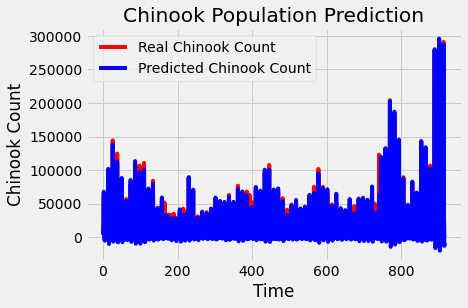

The root mean squared error is 7141.462663113151.


In [72]:
# plot train of nn_model
# plot results 
plot_predictions(y_train, nn_train_preds)
return_rmse(y_train, nn_train_preds)


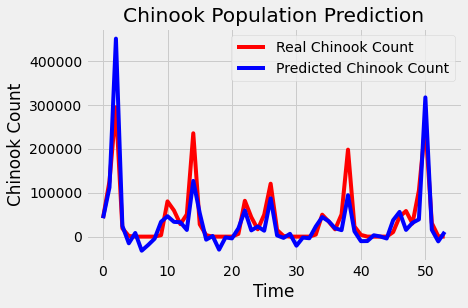

The root mean squared error is 36717.236100895294.


In [73]:
# plot test nn 
# get results 
plot_predictions(y_test, nn_test_preds)
return_rmse(y_test, nn_test_preds)

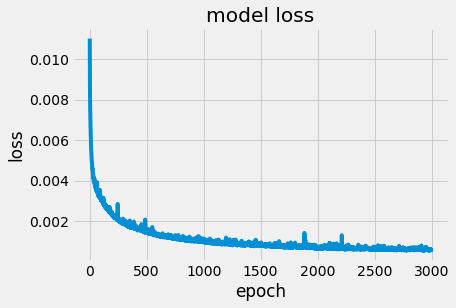

In [74]:
# plot loss
plot_loss(history_nn)